**TEAM 10**

**E.VIGNESH (CB.EN.P2DSC21010)**

**N.SAI DHANUSH (CB.EN.P2DSC21016)**

**QUESTION 1:**

**Perform ASR using GMM-HMM using MFCC features (instead of maximum peaks in the spectrum)
on the dataset of the google code project by Hakon Sandsmark.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Dependencies**

In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas
%matplotlib inline  
import os
import zipfile
from zipfile import ZipFile
import librosa

**Download Data**

In [3]:
from librosa.core.convert import Z_weighting
zf = '/content/drive/MyDrive/Colab Notebooks/DATA/hmm-speech-recognition-0.1.zip'

In [4]:
# opening the zip file in READ mode
with ZipFile(zf, 'r') as z:
    # printing all the contents of the zip file
    z.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    z.extractall('/content/drive/MyDrive/Colab Notebooks/DATA/speech-e8')
    print('Done!')

File Name                                             Modified             Size
hmm-speech-recognition-0.1/                    2010-12-15 20:17:42            0
hmm-speech-recognition-0.1/audio/              2010-12-14 17:05:56            0
hmm-speech-recognition-0.1/audio/apple/        2010-12-10 21:20:04            0
hmm-speech-recognition-0.1/audio/apple/apple01.wav 2010-12-10 19:33:30         5432
__MACOSX/                                      2010-12-15 20:18:02            0
__MACOSX/hmm-speech-recognition-0.1/           2010-12-15 20:18:02            0
__MACOSX/hmm-speech-recognition-0.1/audio/     2010-12-15 20:18:02            0
__MACOSX/hmm-speech-recognition-0.1/audio/apple/ 2010-12-15 20:18:02            0
__MACOSX/hmm-speech-recognition-0.1/audio/apple/._apple01.wav 2010-12-10 19:33:30           82
hmm-speech-recognition-0.1/audio/apple/apple02.wav 2010-12-10 19:34:00         6546
__MACOSX/hmm-speech-recognition-0.1/audio/apple/._apple02.wav 2010-12-10 19:34:00           82



**Print the words uttered in the given dataset.**

In [5]:

fpaths = []
labels = []
spoken = []
audio= '/content/drive/MyDrive/Colab Notebooks/DATA/speech-e8/hmm-speech-recognition-0.1/audio'
for f in os.listdir(audio):
    for w in os.listdir(audio+'/'+f):
        fpaths.append(audio +'/'+ f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

Words spoken: ['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']


**Extract all the files in the dataset and convert it into a matrix.**

In [6]:

from scipy.io import wavfile

data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

Number of files total: 105
Labels and label indices [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6.]


**Defining a Function "STFT", which takes fft size and overlap_pct.**

In [7]:
# Defining the STFT function 
def stft(x, fftsize=64, overlap_pct=.5):   
    hop = int(fftsize * (1 - overlap_pct))
    w = scipy.hanning(fftsize + 1)[:-1]    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

**Plot the waveform for the word uttered, against Amplitude and Time samples.**

(216, 32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'PSD of apple example')

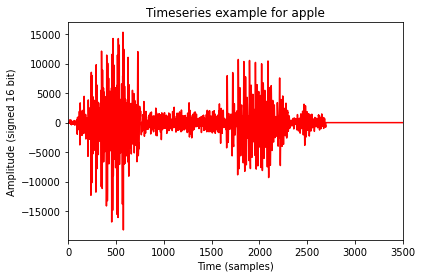

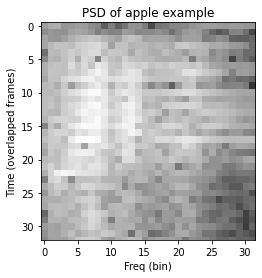

In [8]:
# Plotting the STFT
import matplotlib.pyplot as plt
plt.plot(data[0, :], color='red')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()


log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

**Function which is used to extract MFCC features, which takes file as input and returns squeezed version of numpy array of flattened feature vectors.**

In [9]:
# function to extract MFCC features
def get_mfcc_features(file):
    temp_feats = list()
    try:
          mfcc = librosa.feature.mfcc(file, sr=16000, n_mfcc=13)                # extract the mfcc features
          temp_feats.append(mfcc)                                               # flattening to get a single feature vector
    except:
          pass
    return np.squeeze(np.array(temp_feats))

**Extracting MFCC Features for all the files, whereas earlier we did only for a single file.**

In [10]:
# Extracting the MFCC for all the audio files
all_obs = []
for i in range(data.shape[0]):
    obs = []
    for r in range(data.shape[0]):
        t = get_mfcc_features(data[r,: ])
        obs.append(t.copy())
    if i % 10 == 0:
        print("Processed obs %s" % i)
     
all_obs = np.atleast_3d(obs)

Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90
Processed obs 100


**Implementation of GMM-HMM**

In [16]:

import scipy.stats as st
import numpy as np

class gmmhmm:
    
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(296)
        
        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
           
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:,subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

if __name__ == "__main__":
    rstate = np.random.RandomState(0)
    t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
    t1 /= t1.sum(axis=0)
    t2 = rstate.rand(*t1.shape)
    t2 /= t2.sum(axis=0)
    
    m1 = gmmhmm(2)
    m1.fit(t1)
    m2 = gmmhmm(2)
    m2.fit(t2)
    
    m1t1 = m1.transform(t1)
    m2t1 = m2.transform(t1)
    print("Likelihoods for test set 1")
    print("M1:", m1t1)
    print("M2:", m2t1)
    print("Prediction for test set 1")
    print("Model", np.argmax([m1t1, m2t1]) + 1)
    print()
    
    m1t2 = m1.transform(t2)
    m2t2 = m2.transform(t2)
    print("Likelihoods for test set 2")
    print("M1:", m1t2)
    print("M2:", m2t2)
    print("Prediction for test set 2")
    print("Model", np.argmax([m1t2, m2t2]) + 1)

Likelihoods for test set 1
M1: 225.12630156124433
M2: 216.69368412318693
Prediction for test set 1
Model 1

Likelihoods for test set 2
M1: 36.93172704100051
M2: 37.87947782892246
Prediction for test set 2
Model 2


**Splitting data into Train and Test sets.**

In [18]:
# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( all_obs, all_labels, test_size=0.1, random_state=256)


# Printing the size of training and testing datasets
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (94, 13, 14)
Size of testing matrix: (11, 13, 14)


**Training the model using GMM-HMM.**

****

**Calculating the Test Accuracy**

In [19]:
# training and testing GMM-HMM
ys = set(all_labels)
ms = [gmmhmm(11) for y in ys]
m = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Test accuracy: 18.18 percent


**Plotting the Confusion matrix, to find any misclassifications,if present.**

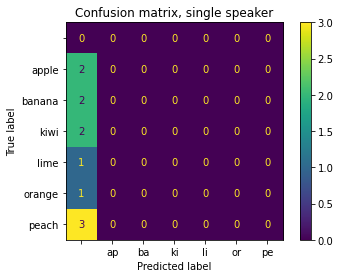

In [14]:
# plotting confusion matrix for finding the unsual pattern in missclassification.
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple'])
cm_display.plot()
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**INFERENCE:**

**By considering MFCC as features for model (GMM-HMM) a test accuracy of 18.18% is obtained.
confusion matrix is also plotted for the same, which helps us to know the misclassifications present during training if any.**

**So, it is obivious that we can use MFCC as model features effectively for Speech recognition.**

